In [1]:
import urllib
from elasticsearch import Elasticsearch
from elasticsearch import helpers
import ConfigParser
import os
import csv
import numpy as np

In [8]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers
import ConfigParser
import os

#read in the config file
config = ConfigParser.ConfigParser()

#print os.path.isfile() 
config.read(os.getcwd() + "/Infra_2/capstone_config.ini")

# ES_url = config.get('ElasticSearch','host')
# ES_password = config.get('ElasticSearch','password')
# ES_username= config.get('ElasticSearch','username')

# ES_url = "http://169.53.138.85:5601/"
ES_url = "169.53.138.85"
ES_username = 'accident'
ES_password = 'Dav1dC0C0'
line = 'http://' + ES_username + ':' + ES_password + '@' + ES_url + ':9200/'

es = Elasticsearch(['http://' + ES_username + ':' + ES_password + '@' + ES_url + ':9200/'])

res = es.search(index="saferoad",doc_type='collisions', body={"query": {"match_all": {}}})
print("Got %d Hits:" % res['hits']['total'])

#print first 2 out of 726934 just check stuff out,
index = 0
for hit in res['hits']['hits']:
    print hit
    #print contributing factor just for the heck of it
#     print("%(CONTRIBUTING FACTOR VEHICLE 1)s" % hit["_source"])
    index+=1
    if index == 10:
        break

Got 726934 Hits:
{u'_score': 1.0, u'_type': u'collisions', u'_id': u'1f08424b26001ee79e3ef7fd8704358b6068bd5c058ea77a139d2dcd', u'_source': {u'NUMBER OF CYCLIST KILLED': u'0', u'CONTRIBUTING FACTOR VEHICLE 1': u'Unspecified', u'CONTRIBUTING FACTOR VEHICLE 2': u'Unspecified', u'CONTRIBUTING FACTOR VEHICLE 3': u'', u'CONTRIBUTING FACTOR VEHICLE 4': u'', u'CONTRIBUTING FACTOR VEHICLE 5': u'', u'ZIP CODE': u'', u'DATETIME_C': u'2016-01-19T16:45:00', u'DATE': u'01/19/2016', u'OFF STREET NAME': u'P/L OF RICHMOND AVE AND VICTORY BLVD', u'NUMBER OF MOTORIST KILLED': u'0', u'LOCATION': u'', u'ON STREET NAME': u'', u'UNIQUE KEY': u'3374464', u'CROSS STREET NAME': u'', u'NUMBER OF MOTORIST INJURED': u'0', u'LONGITUDE': u'', u'NUMBER OF PEDESTRIANS INJURED': u'0', u'NUMBER OF PEDESTRIANS KILLED': u'0', u'ID': u'1f08424b26001ee79e3ef7fd8704358b6068bd5c058ea77a139d2dcd', u'VEHICLE TYPE CODE 4': u'', u'VEHICLE TYPE CODE 5': u'', u'VEHICLE TYPE CODE 1': u'PASSENGER VEHICLE', u'VEHICLE TYPE CODE 2': u'

In [21]:
# csvfile = "NYPD_Motor_Vehicle_Collisions.csv"
csvfile = "NYPD_Motor_Vehicle_Collisions_100lines.csv"

f_out = open("NYPD_Motor_Vehicle_Collisions_100lines_csvreadwrite.csv", 'wb+')
writer = csv.writer(f_out)

with open(csvfile, 'rb') as f:
    reader = csv.reader(f, delimiter=',')
#     print f.readline()
    i=0
    for row in reader:
        print i, len(row)
        writer.writerow(row)
        if i<2:
            for c in range(len(row)):
                print c,row[c]
            i+=1
            continue
#         if i in [12,13]:
#             for c in range(len(row)):
#                 print i,c,row[c]
#             i+=1
#             continue
        
        i+=1
#         if i>100:
#             break

f_out.close()

0 29
0 DATE
1 TIME
2 BOROUGH
3 ZIP CODE
4 LATITUDE
5 LONGITUDE
6 LOCATION
7 ON STREET NAME
8 CROSS STREET NAME
9 OFF STREET NAME
10 NUMBER OF PERSONS INJURED
11 NUMBER OF PERSONS KILLED
12 NUMBER OF PEDESTRIANS INJURED
13 NUMBER OF PEDESTRIANS KILLED
14 NUMBER OF CYCLIST INJURED
15 NUMBER OF CYCLIST KILLED
16 NUMBER OF MOTORIST INJURED
17 NUMBER OF MOTORIST KILLED
18 CONTRIBUTING FACTOR VEHICLE 1
19 CONTRIBUTING FACTOR VEHICLE 2
20 CONTRIBUTING FACTOR VEHICLE 3
21 CONTRIBUTING FACTOR VEHICLE 4
22 CONTRIBUTING FACTOR VEHICLE 5
23 UNIQUE KEY
24 VEHICLE TYPE CODE 1
25 VEHICLE TYPE CODE 2
26 VEHICLE TYPE CODE 3
27 VEHICLE TYPE CODE 4
28 VEHICLE TYPE CODE 5
1 29
0 02/02/2016
1 16:00
2 QUEENS
3 11691
4 40.6062278
5 -73.7597764
6 (40.6062278, -73.7597764)
7 EGGERT PLACE
8 MOTT AVENUE
9 
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 Unspecified
19 Unspecified
20 
21 
22 
23 3382352
24 BUS
25 SPORT UTILITY / STATION WAGON
26 
27 
28 
2 29
3 29
4 29
5 29
6 29
7 29
8 29
9 29
10 29
11 29
12 29
13 29


In [2]:
from numpy import genfromtxt
import pandas as pd
from datetime import date, datetime, time

myData = pd.read_csv("NYPD_Motor_Vehicle_Collisions_firstHalf.csv")
# my_data = genfromtxt("NYPD_Motor_Vehicle_Collisions_100lines_csvreadwrite.csv", delimiter=',', skip_header=1, invalid_raise=0)
# print myData
print myData.columns
myData = myData.drop(myData.columns[3:], axis=1)
# print myData

## Date features: Month of year, day of week, hour of day
# Create Day of Week feature
def get_day_of_week(datestr):
    return datetime.strptime(datestr,'%m/%d/%Y').weekday()
myData['day_of_week'] = myData['DATE'].apply(get_day_of_week)

# Create Month of Year feature
def get_month(datestr):
    return datetime.strptime(datestr,'%m/%d/%Y').month
myData['month'] = myData['DATE'].apply(get_month)

# Create Hour feature
def get_hour(timestr):
    return datetime.strptime(timestr,'%H:%M').hour
myData['hour'] = myData['TIME'].apply(get_hour)


features = myData.drop(['TIME'], axis=1)
features['count']=1

# ## Create Borough Features: 
print myData['BOROUGH'].unique()
boroughs = pd.get_dummies(features['BOROUGH'])
# print boroughs[:10]

features = pd.concat([features,boroughs], axis=1)


features_agg = features.groupby(['DATE', 'hour', 'BOROUGH', 'day_of_week', 'month', 
                                'STATEN ISLAND', 'QUEENS', 'MANHATTAN', 'BROOKLYN', 'BRONX']).sum()
# print features_agg[:10]

train = features_agg.reset_index()

train = train.drop(['DATE','BOROUGH'], axis=1)

print train[:20]

y_train = train['count']
x_train = train.drop(['count'], axis=1)


Index([u'DATE', u'TIME', u'BOROUGH', u'ZIP CODE', u'LATITUDE', u'LONGITUDE',
       u'LOCATION', u'ON STREET NAME', u'CROSS STREET NAME',
       u'OFF STREET NAME', u'NUMBER OF PERSONS INJURED',
       u'NUMBER OF PERSONS KILLED', u'NUMBER OF PEDESTRIANS INJURED',
       u'NUMBER OF PEDESTRIANS KILLED', u'NUMBER OF CYCLIST INJURED',
       u'NUMBER OF CYCLIST KILLED', u'NUMBER OF MOTORIST INJURED',
       u'NUMBER OF MOTORIST KILLED', u'CONTRIBUTING FACTOR VEHICLE 1',
       u'CONTRIBUTING FACTOR VEHICLE 2', u'CONTRIBUTING FACTOR VEHICLE 3',
       u'CONTRIBUTING FACTOR VEHICLE 4', u'CONTRIBUTING FACTOR VEHICLE 5',
       u'UNIQUE KEY', u'VEHICLE TYPE CODE 1', u'VEHICLE TYPE CODE 2',
       u'VEHICLE TYPE CODE 3', u'VEHICLE TYPE CODE 4', u'VEHICLE TYPE CODE 5'],
      dtype='object')
['STATEN ISLAND' 'QUEENS' nan 'MANHATTAN' 'BROOKLYN' 'BRONX']
    hour  day_of_week  month  STATEN ISLAND  QUEENS  MANHATTAN  BROOKLYN  \
0      0            1      1              0       0          0     

In [138]:
y_train = train['count']
x_train = train.drop(['count'], axis=1)

In [59]:
data = np.array(features)
print data.shape

(373000, 8)


In [102]:
# from sklearn.linear_model import LinearRegression
from sklearn import linear_model

regr = linear_model.Ridge(alpha=0.5) 
regr.fit(x_train, y_train)

print regr.score(x_train, y_train)

print regr.coef_
print regr.intercept_

print regr.predict(x_train[:10])
print np.array(y_train[:10])

print x_train[:2]

print np.sqrt(np.sum((regr.predict(x_train)-y_train)**2))/y_train.shape[0]

print np.mean(y_train)
print y_train.shape[0]


0.242076668764
[ 0.1186168  -0.13110397  0.01464904 -2.39376254  0.89527878  1.04522075
  1.72408667 -1.27082367]
2.92178394705
[ 1.53450536  3.85054977  3.70060781  1.65312215  4.64803248  3.96916657
  3.8192246   0.53018327  1.77173895  4.76664928]
[1 5 3 4 8 4 2 1 3 7]
   hour  day_of_week  month  STATEN ISLAND  QUEENS  MANHATTAN  BROOKLYN  BRONX
0     0            1      1              0       0          0         0      1
1     0            1      1              0       0          1         0      0
0.0112349334124
4.36032740409
65607


In [122]:
for y in range(12):
    i = np.array((np.array(y_train)==y))
    
    print y, x_train[i].shape[0], np.sum(regr.predict(x_train[i]))/x_train[i].shape[0]


0 0 nan
1 13929 3.14703510129
2 10744 3.69877742926
3 8588 4.14871809297
4 6951 4.57719062132
5 5595 4.94061360036
6 4739 5.19584866345
7 3851 5.31578650101
8 3179 5.46315839088
9 2505 5.5124078273
10 1785 5.57326358783
11 1279 5.61518581213


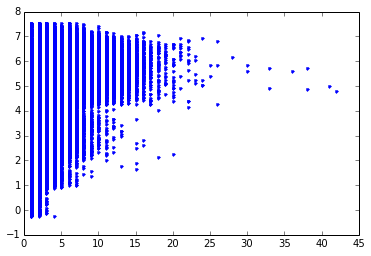

In [126]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.plot(y_train, regr.predict(x_train),'.')
plt.show()

In [151]:
print x_train[:10]
print x_train['day_of_week'].unique()
x_train['day_of_week_name']=np.zeros(x_train.shape[0])
x_train['day_of_week_name'][np.array(x_train['day_of_week']==0)]='Sunday'
x_train['day_of_week_name'][x_train['day_of_week']==1]='Monday'
x_train['day_of_week_name'][x_train['day_of_week']==2]='Tuesday'
x_train['day_of_week_name'][x_train['day_of_week']==3]='Wednesday'
x_train['day_of_week_name'][x_train['day_of_week']==4]='Thursday'
x_train['day_of_week_name'][x_train['day_of_week']==5]='Friday'
x_train['day_of_week_name'][x_train['day_of_week']==6]='Saturday'

x_train['month_name']=np.zeros(x_train.shape[0])
x_train['month_name'][x_train['month']==0]='January'
x_train['month_name'][x_train['month']==1]='February'
x_train['month_name'][x_train['month']==2]='March'
x_train['month_name'][x_train['month']==3]='April'
x_train['month_name'][x_train['month']==4]='May'
x_train['month_name'][x_train['month']==5]='June'
x_train['month_name'][x_train['month']==6]='July'
x_train['month_name'][x_train['month']==7]='August'
x_train['month_name'][x_train['month']==8]='September'
x_train['month_name'][x_train['month']==9]='October'
x_train['month_name'][x_train['month']==10]='November'
x_train['month_name'][x_train['month']==11]='December'

x_train['hour_str']=np.zeros(x_train.shape[0])
x_train['hour_str'][x_train['hour']==0]='00:00'
x_train['hour_str'][x_train['hour']==1]='01:00'
x_train['hour_str'][x_train['hour']==2]='02:00'
x_train['hour_str'][x_train['hour']==3]='03:00'
x_train['hour_str'][x_train['hour']==4]='04:00'
x_train['hour_str'][x_train['hour']==5]='05:00'
x_train['hour_str'][x_train['hour']==6]='06:00'
x_train['hour_str'][x_train['hour']==7]='07:00'
x_train['hour_str'][x_train['hour']==8]='08:00'
x_train['hour_str'][x_train['hour']==9]='09:00'
x_train['hour_str'][x_train['hour']==10]='10:00'
x_train['hour_str'][x_train['hour']==11]='11:00'
x_train['hour_str'][x_train['hour']==12]='12:00'
x_train['hour_str'][x_train['hour']==13]='13:00'
x_train['hour_str'][x_train['hour']==14]='14:00'
x_train['hour_str'][x_train['hour']==15]='15:00'
x_train['hour_str'][x_train['hour']==16]='16:00'
x_train['hour_str'][x_train['hour']==17]='17:00'
x_train['hour_str'][x_train['hour']==18]='18:00'
x_train['hour_str'][x_train['hour']==19]='19:00'
x_train['hour_str'][x_train['hour']==20]='20:00'
x_train['hour_str'][x_train['hour']==21]='21:00'
x_train['hour_str'][x_train['hour']==22]='22:00'
x_train['hour_str'][x_train['hour']==23]='23:00'

print x_train[:10]
print x_train['day_of_week_name'].unique()

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

   hour  day_of_week  month  STATEN ISLAND  QUEENS  MANHATTAN  BROOKLYN  \
0     0            1      1              0       0          0         0   
1     0            1      1              0       0          1         0   
2     0            1      1              0       1          0         0   
3     1            1      1              0       0          0         0   
4     1            1      1              0       0          0         1   
5     1            1      1              0       0          1         0   
6     1            1      1              0       1          0         0   
7     1            1      1              1       0          0         0   
8     2            1      1              0       0          0         0   
9     2            1      1              0       0          0         1   

   BRONX day_of_week_name month_name hour_str  
0      1           Monday   February    12:00  
1      0           Monday   February    12:00  
2      0           Monday   Fe

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
print x_train[:3]
print 24+7+12+5

[[ 0.  1.  1.  0.  0.  0.  0.  1.]
 [ 0.  1.  1.  0.  0.  1.  0.  0.]
 [ 0.  1.  1.  0.  1.  0.  0.  0.]]
48


In [29]:
# from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

enc = preprocessing.OneHotEncoder()
enc.fit(x_train[:,:3])
print enc.n_values_

x_train_enc = enc.transform(x_train[:,:3])
print type(x_train_enc)
print "x_train_enc.shape: ",x_train_enc.shape

print "x_train.shape: ",np.array(x_train).shape
x_train = np.array(x_train)

x_train_enc = np.concatenate((x_train_enc.todense(), x_train[:,3:]), axis=1)
print "x_train_enc.shape: ",x_train_enc.shape

for i in range(1,10):
    print "Hour: ",x_train[i,0], x_train_enc[i,:24]
    print "Day of week: ",x_train[i,1], x_train_enc[i,24:31]
    print "Month: ",x_train[i,2], x_train_enc[i,31:43]
    print "Burough: ",x_train[i,3:], x_train_enc[i,43:]
    

[24  7 13]
<class 'scipy.sparse.csr.csr_matrix'>
x_train_enc.shape:  (65607, 43)
x_train.shape:  (65607, 8)
x_train_enc.shape:  (65607, 48)
Hour:  0.0 [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]]
Day of week:  1.0 [[ 0.  1.  0.  0.  0.  0.  0.]]
Month:  1.0 [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Burough:  [ 0.  0.  1.  0.  0.] [[ 0.  0.  1.  0.  0.]]
Hour:  0.0 [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]]
Day of week:  1.0 [[ 0.  1.  0.  0.  0.  0.  0.]]
Month:  1.0 [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Burough:  [ 0.  1.  0.  0.  0.] [[ 0.  1.  0.  0.  0.]]
Hour:  1.0 [[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]]
Day of week:  1.0 [[ 0.  1.  0.  0.  0.  0.  0.]]
Month:  1.0 [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Burough:  [ 0.  0.  0.  0.  1.] [[ 0.  0.  0.  0.  1.]]
Hour:  1.0 

In [32]:
from sklearn import linear_model

regr = linear_model.Ridge(alpha=0.5) 
regr.fit(x_train_enc, y_train)

print regr.score(x_train_enc, y_train)

print regr.coef_
print regr.intercept_

print regr.predict(x_train_enc[:10])
print np.array(y_train[:10])

print x_train_enc[:2]

print np.sqrt(np.sum((regr.predict(x_train_enc)-y_train)**2))/y_train.shape[0]

print np.mean(y_train)
print y_train.shape[0]


0.461168840762
[-1.74874664 -2.20610977 -2.36333968 -2.44986883 -2.35458245 -2.4524178
 -2.08394612 -1.4848596   1.37916204  1.36853445  1.03389651  1.13447331
  1.36387801  1.7097634   2.24459058  1.62366462  2.73766019  2.41597722
  1.82648039  0.89930345  0.23343318 -0.49844496 -0.90681872 -1.42168276
  0.05290451  0.16550169  0.12460887  0.13708506  0.5282109  -0.27535979
 -0.73295124 -0.26629184 -0.07017175 -0.18593132 -0.06908383  0.28029451
  0.37046362 -0.01014816 -0.12762784  0.04080068  0.01244408  0.01664732
  0.00860451 -2.71316211  0.99649106  1.17706667  1.85882572 -1.31922136]
3.76672030004
[ 0.59796215  3.09425018  2.91367457  0.14059902  3.3186461   2.63688705
  2.45631144 -1.25334173 -0.01663088  3.1614162 ]
[1 5 3 4 8 4 2 1 3 7]
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  

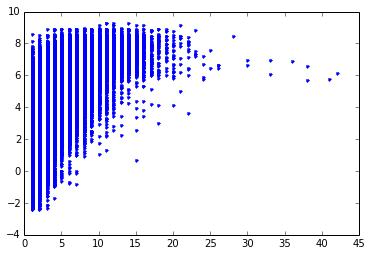

[[False]
 [False]
 [False]
 ..., 
 [False]
 [False]
 [False]]
[96]
(65607, 48)
(65607,)
(65607,)


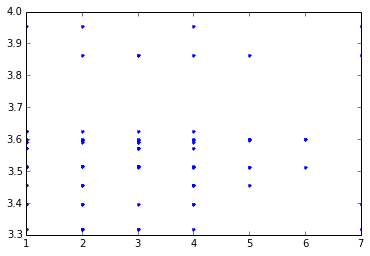

'\ncols = range(24)+range(7)+range(1,13)+["STATEN ISLAND", "QUEENS", "MANHATTAN", "BROOKLYN", "BRONX"]\nx_train_enc\nn, bins, patches = plt.hist(x, 50, normed=1, facecolor=\'green\', alpha=0.75)\n'

In [65]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.plot(y_train, regr.predict(x_train_enc),'.')
plt.show()


hours_lookup = {0:"12:00 am", 1:"1:00 am", 2:"2:00 am", 3:"3:00 am", 4:"4:00 am", 5:"5:00 am", 6:"6:00 am",
               7:"7:00 am", 8:"8:00 am", 9:"9:00 am", 10:"10:00 am", 11:"11:00 am", 12:"12:00 pm", 13:"1:00 pm",
               14:"2:00 pm", 15:"3:00 pm", 16:"4:00 pm", 17:"5:00 pm", 18:"6:00 pm", 19:"7:00 pm", 20:"8:00 pm",
               21:"9:00 pm", 22:"10:00 pm", 23:"11:00 pm"}
hours_map = {v: k for k, v in hours_lookup.items()}
hours_offset = 0

days_lookup = {0:"Sunday", 1:"Monday", 2:"Tuesday", 3:"Wednesday", 4:"Thursday", 5:"Friday", 6:"Saturday"}
days_map = {v: k for k, v in days_lookup.items()}
days_offset = len(hours_lookup.keys())

months_lookup = {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 
                7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}
months_map = {v: k for k, v in months_lookup.items()}
months_offset = days_offset+len(days_lookup.keys())

burroughs_map = {"STATEN ISLAND":0, "QUEENS":1, "MANHATTAN":2, "BROOKLYN":3, "BRONX":4}
burroughs_offset = months_offset+len(months_lookup.keys())

# Manhattan, January, Tuesday, 7am
hr_col = hours_offset+hours_map["7:00 am"]
dy_col = days_offset+days_map["Tuesday"]
mn_col = months_offset+months_map["Jan"]
br_col = burroughs_offset+burroughs_map["MANHATTAN"]

rows = np.all([x_train_enc[:,hr_col]==1, x_train_enc[:,dy_col]==1, x_train_enc[:,mn_col]==1, x_train_enc[:,br_col]==1], axis=0)
rows = np.all([x_train_enc[:,hr_col]==1, x_train_enc[:,dy_col]==1, x_train_enc[:,br_col]==1], axis=0)
print rows
print sum(rows)

print x_train_enc.shape
rows = rows[:,0]
print rows.shape
print y_train.shape
x_example = x_train_enc[rows,:]
y_example = y_train[rows]

plt.plot(y_example, regr.predict(x_example),'.')
plt.show()

'''
cols = range(24)+range(7)+range(1,13)+["STATEN ISLAND", "QUEENS", "MANHATTAN", "BROOKLYN", "BRONX"]
x_train_enc
n, bins, patches = plt.hist(x, 50, normed=1, facecolor='green', alpha=0.75)
'''


Accidents per day in each borough



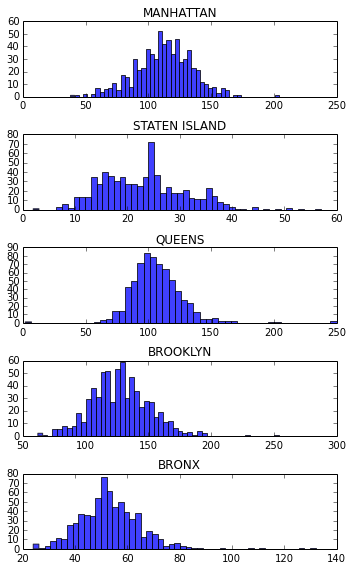

In [93]:
# accidents per burough per day
aggtable1 = features.groupby(['DATE', 'BOROUGH',  
                                'STATEN ISLAND', 'QUEENS', 'MANHATTAN', 'BROOKLYN', 'BRONX']).sum()
aggtable1 = aggtable1.drop(['day_of_week','hour','month'], axis=1)
aggtable1 = aggtable1.reset_index()
# print aggtable1[:10]
# print aggtable1['MANHATTAN']==1
# print aggtable1[aggtable1['MANHATTAN']==1]['count']

print "\nAccidents per day in each borough\n"
f,axarr = plt.subplots(5,1, figsize=(5,8))

# n, bins, patches = plt.hist(aggtable1['count'], 50, alpha=0.75)
# n, bins, patches = plt.hist(np.array(aggtable1[aggtable1['MANHATTAN']==1]['count']), 50, alpha=0.75)
axarr[0].hist(np.array(aggtable1[aggtable1['MANHATTAN']==1]['count']), 50, alpha=0.75)
axarr[0].set_title('MANHATTAN')
axarr[1].hist(np.array(aggtable1[aggtable1['STATEN ISLAND']==1]['count']), 50, alpha=0.75)
axarr[1].set_title('STATEN ISLAND')
axarr[2].hist(np.array(aggtable1[aggtable1['QUEENS']==1]['count']), 50, alpha=0.75)
axarr[2].set_title('QUEENS')
axarr[3].hist(np.array(aggtable1[aggtable1['BROOKLYN']==1]['count']), 50, alpha=0.75)
axarr[3].set_title('BROOKLYN')
axarr[4].hist(np.array(aggtable1[aggtable1['BRONX']==1]['count']), 50, alpha=0.75)
axarr[4].set_title('BRONX')

plt.tight_layout()
plt.show()


#train = features_agg.reset_index()


['BRONX' 'BROOKLYN' 'MANHATTAN' 'QUEENS' 'STATEN ISLAND']

Accidents per day in each borough weekdays and weekends



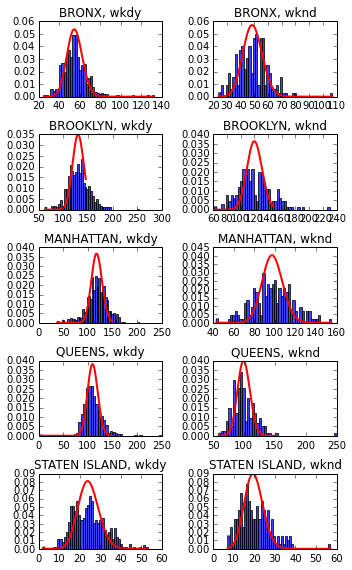

In [172]:
# accidents per burough per day
aggtable2 = features.groupby(['DATE','day_of_week', 'BOROUGH',  
                                'STATEN ISLAND', 'QUEENS', 'MANHATTAN', 'BROOKLYN', 'BRONX']).sum()
aggtable2 = aggtable2.reset_index()
aggtable2 = aggtable2.drop(['hour','month'], axis=1)
# print aggtable2[:10]

# print np.array(aggtable2['MANHATTAN']==1)
# print np.array(aggtable2['day_of_week']>0)
# print np.array(aggtable2['day_of_week']<6)
# print np.all([np.array(aggtable2['MANHATTAN']==1), np.array(aggtable2['day_of_week']>0), np.array(aggtable2['day_of_week']<6)], axis=0)
# print aggtable2[np.all([np.array(aggtable2['MANHATTAN']==1), np.array(aggtable2['day_of_week']>0), np.array(aggtable2['day_of_week']<6)], axis=0)]['count']

wkdy_rows = np.all([np.array(aggtable2['day_of_week']>0), np.array(aggtable2['day_of_week']<6)], axis=0)

boroughs = pd.unique(aggtable2['BOROUGH'])
print boroughs


# poisson function, parameter lamb is the fit parameter (equal to mean)
def poisson(k, lamb):
    return (1.0*lamb**k/factorial(k)) * np.exp(-lamb)

# count_per_day = np.array(wkdy_accdnts_per_day_Qns[np.all([np.array(wkdy_accdnts_per_day_Qns>50), np.array(wkdy_accdnts_per_day_Qns<175)], axis=0)])

# plot poisson-deviation with fitted parameter
# x_plot = np.linspace(np.min(count_per_day), np.max(count_per_day), 1000)

# plt.plot(x_plot, poisson(x_plot, np.mean(count_per_day)), 'r-', lw=2)


print "\nAccidents per day in each borough weekdays and weekends\n"
f,axarr = plt.subplots(5,2, figsize=(5,8))

for i,br in enumerate(boroughs):
    wkdy_accdnts_per_day = np.array(aggtable2[np.all([np.array(aggtable2[br]==1), wkdy_rows], axis=0)]['count'])
    x_plot = np.linspace(np.min(wkdy_accdnts_per_day), np.max(wkdy_accdnts_per_day), 1000)
    axarr[i,0].hist(np.array(wkdy_accdnts_per_day), 50, alpha=0.75, normed=True)
    axarr[i,0].plot(x_plot, poisson(x_plot, np.mean(wkdy_accdnts_per_day)), 'r-', lw=2)
    axarr[i,0].set_title(br+', wkdy')
    
wknd_rows = np.any([np.array(aggtable2['day_of_week']==0), np.array(aggtable2['day_of_week']==6)], axis=0) 
for i,br in enumerate(boroughs):
    wknd_accdnts_per_day = aggtable2[np.all([np.array(aggtable2[br]==1), wknd_rows], axis=0)]['count']
    x_plot = np.linspace(np.min(wknd_accdnts_per_day), np.max(wknd_accdnts_per_day), 1000)
    axarr[i,1].hist(np.array(wknd_accdnts_per_day), 50, alpha=0.75, normed=True)
    axarr[i,1].plot(x_plot, poisson(x_plot, np.mean(wknd_accdnts_per_day)), 'r-', lw=2)
    axarr[i,1].set_title(br+', wknd')

'''

wkdy_accdnts_per_day_Mnht = aggtable2[np.all([np.array(aggtable2['MANHATTAN']==1), wkdy_rows], axis=0)]['count']
wkdy_accdnts_per_day_SI = aggtable2[np.all([np.array(aggtable2['STATEN ISLAND']==1), wkdy_rows], axis=0)]['count']
wkdy_accdnts_per_day_Qns = aggtable2[np.all([np.array(aggtable2['QUEENS']==1), wkdy_rows], axis=0)]['count']
wkdy_accdnts_per_day_Bkn = aggtable2[np.all([np.array(aggtable2['BROOKLYN']==1), wkdy_rows], axis=0)]['count']
wkdy_accdnts_per_day_Bnx = aggtable2[np.all([np.array(aggtable2['BRONX']==1), wkdy_rows], axis=0)]['count']


# print np.array(aggtable2['MANHATTAN']==1)
# print np.array(aggtable2['day_of_week']==0)
# print np.array(aggtable2['day_of_week']==6)
# print np.any([np.array(aggtable2['day_of_week']==0), np.array(aggtable2['day_of_week']==6)], axis=0)
# print np.sum(np.any([np.array(aggtable2['day_of_week']==0), np.array(aggtable2['day_of_week']==6)], axis=0))


# print np.all([np.array(aggtable2['MANHATTAN']==1), wknd_rows], axis=0)

for i,br in enumerate(boroughs):
    break
wknd_accdnts_per_day_Mnht = aggtable2[np.all([np.array(aggtable2['MANHATTAN']==1), wknd_rows], axis=0)]['count']
wknd_accdnts_per_day_SI = aggtable2[np.all([np.array(aggtable2['STATEN ISLAND']==1), wknd_rows], axis=0)]['count']
wknd_accdnts_per_day_Qns = aggtable2[np.all([np.array(aggtable2['QUEENS']==1), wknd_rows], axis=0)]['count']
wknd_accdnts_per_day_Bkn = aggtable2[np.all([np.array(aggtable2['BROOKLYN']==1), wknd_rows], axis=0)]['count']
wknd_accdnts_per_day_Bnx = aggtable2[np.all([np.array(aggtable2['BRONX']==1), wknd_rows], axis=0)]['count']



# n, bins, patches = plt.hist(aggtable1['count'], 50, alpha=0.75)
# n, bins, patches = plt.hist(np.array(aggtable1[aggtable1['MANHATTAN']==1]['count']), 50, alpha=0.75)

axarr[1,0].hist(np.array(wkdy_accdnts_per_day_SI), 50, alpha=0.75)
axarr[1,0].set_title('STATEN ISLAND, wkdy')
axarr[2,0].hist(np.array(wkdy_accdnts_per_day_Qns), 50, alpha=0.75)
axarr[2,0].set_title('QUEENS, wkdy')
axarr[3,0].hist(np.array(wkdy_accdnts_per_day_Bkn), 50, alpha=0.75)
axarr[3,0].set_title('BROOKLYN, wkdy')
axarr[4,0].hist(np.array(wkdy_accdnts_per_day_Bnx), 50, alpha=0.75)
axarr[4,0].set_title('BRONX, wkdy')

axarr[0,1].hist(np.array(wknd_accdnts_per_day_Mnht), 50, alpha=0.75)
axarr[0,1].set_title('MANHATTAN, wknd')
axarr[1,1].hist(np.array(wknd_accdnts_per_day_SI), 50, alpha=0.75)
axarr[1,1].set_title('STATEN ISLAND, wknd')
axarr[2,1].hist(np.array(wknd_accdnts_per_day_Qns), 50, alpha=0.75)
axarr[2,1].set_title('QUEENS, wknd')
axarr[3,1].hist(np.array(wknd_accdnts_per_day_Bkn), 50, alpha=0.75)
axarr[3,1].set_title('BROOKLYN, wknd')
axarr[4,1].hist(np.array(wknd_accdnts_per_day_Bnx), 50, alpha=0.75)
axarr[4,1].set_title('BRONX, wknd')

'''
plt.tight_layout()
plt.show()


#train = features_agg.reset_index()


## Poisson Regression

In [178]:
from statsmodels.discrete import discrete_model

print x_train_enc[:3]

pregr = discrete_model.Poisson(x_train_enc, y_train, offset=None, exposure=None, missing='none')
results = pregr.fit()
print(results.summary())

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]]


ValueError: operands could not be broadcast together with shapes (65607,48) (65607) 